# **Evaluate Retrieval**

In this notebook, we focus on **evaluating the retrieval performance** of our system. This involves loading the necessary configurations, embedding the text data, performing retrieval using Azure Cognitive Search, and evaluating the results using various metrics.

### Objectives:
- **Load Configurations:** Load the necessary configurations from the environment file.
- **Embed Text Data:** Use the Azure OpenAI service to embed the text data.
- **Perform Retrieval:** Use Azure Cognitive Search to perform retrieval based on the embedded text data.
- **Evaluate Results:** Evaluate the retrieval performance using metrics such as accuracy, precision, recall, F1 score, and confusion matrix.

### Key Steps:
1. **Load Configurations:** Load the necessary configurations from the environment file.
2. **Embed Text Data:** Embed the text data using the Azure OpenAI service.
3. **Perform Retrieval:** Perform retrieval using Azure Cognitive Search.
4. **Evaluate Results:** Evaluate the retrieval performance using various metrics.

This notebook ensures that the retrieval system is evaluated effectively, providing insights into its performance and areas for improvement.

In [ ]:
import json
from dotenv import dotenv_values, load_dotenv
from typing import List
from typing_extensions import Annotated

from pydantic import BaseModel, Field

from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.models import VectorizableTextQuery

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import AzureChatOpenAI

from utils.genai.invoker import embed_text

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn metrics for evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    confusion_matrix
)

config = dotenv_values(".env")

aoai_endpoint = config["AZURE_OPENAI_API_BASE"]
aoai_key = config["AZURE_OPENAI_API_KEY"]
aoai_api_version = config["AZURE_OPENAI_API_VERSION"]
aoai_chat_model = config["AZURE_OPENAI_MODEL"]
aoai_chat_model_mini = config["AZURE_OPENAI_MODEL_MINI"]
aoai_embedding_model = config["AZURE_OPENAI_EMBEDDING_MODEL"]
search_endpoint = config["SEARCH_ENDPOINT"]
search_key = config["SEARCH_KEY"]
credential = AzureKeyCredential(search_key)

In [2]:
class QuestionSchema(BaseModel):
    """
    Schema for the JSON response returned by the LLM.
    The 'queries' field is a list of synthetic questions.
    """
    queries: Annotated[
        List[str],
        Field(..., description="A list of rewritten variations of the original question or sub-questions related to the original topic.")
    ]

In [3]:
def get_query_analyzer(query):
    system = """You are an expert at converting user questions into search queries. \
    You have access to a search index of customer reviews and product specifications. \
    Given a user question, your task is to rewrite and break down the question into smaller multiple variations or sub-questions. \
    The idea is to cover a broader area of the document space to find more relevant product related documents. \
    example:
        Question: "Tell me about Product A"
        Output: {{"queries": ["what are the main features of Product A?", "Can you tell me some review regarding Product A", "Who have recently purchased Product A?"]}}

        Question: "How many features does product A have, and when was it released?"
        Output: {{"queries": ["Feature list of Product A", "When was product A released"]}}
            

    If there are acronyms or words you are not familiar with, do not try to rephrase them."""

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{question}"),
        ]
    )
    llm = AzureChatOpenAI(
        model=aoai_chat_model,
        api_key=aoai_key,
        azure_endpoint=aoai_endpoint,
        api_version=aoai_api_version,
        temperature=0
    )

    try:
        structured_llm = llm.with_structured_output(QuestionSchema)
        query_analyzer = prompt | structured_llm
        response = query_analyzer.invoke({"question": query})
        return response
    except Exception as e:
        print(e)

### **Scoring Metrics**

##### **Reranker Score (`search.reranker_score`)**

| Score | Meaning |
|-------|---------|
| **4.0** | Highly relevant – the document fully answers the question (may include extra text). |
| **3.0** | Relevant – answers the question but lacks some details. |
| **2.0** | Somewhat relevant – partially answers the question or only covers some aspects. |
| **1.0** | Minimally relevant – only a small part of the question is addressed. |
| **0.0** | Irrelevant. |

##### **BM25 Score (`search.score`)**

- **Range:** Unbounded.
- **Interpretation:** A higher BM25 score indicates greater relevance, as it measures document-query matching based on term frequency and inverse document frequency.


In [4]:
def get_search_results(query, index, rewrite=False, k=1):
    if rewrite:
        try:
            # Optionally rewrite the query with an LLM
            query_items = get_query_analyzer(query)        
            formatted_queries = [f'"{rewritten_query}"' for rewritten_query in query_items.queries]
            search_text = " OR ".join(formatted_queries)
        except Exception as e:
            print(e)
    else:
        search_text = query
        formatted_queries = [query]
        semantic_query = query

    try:
        search_client = SearchClient(endpoint=search_endpoint, index_name=index, credential=credential)
        results = search_client.search(
            search_text=search_text,
            vector_queries=[
                VectorizableTextQuery(
                    text=formatted_query,
                    k_nearest_neighbors=50,  # keep this as needed
                    fields="text_vector"
                )
                for formatted_query in formatted_queries
            ],
            search_mode="any",
            search_fields=["chunk"],
            semantic_query=semantic_query,
            semantic_configuration_name="product-customer-vector-semantic-configuration",
            top=k  # use the parameter k here
        )

        # Format search results
        data = []
        for result in results:
            data.append({
                "chunk_id": result["chunk_id"],
                "text_vector": result["text_vector"],
                "search_score": result["@search.score"],
                "reranker_score": result["@search.reranker_score"],
            })
        return data
    except Exception as e:
        print(e)
        return None


### **Read Data**

In [5]:
fpath='data/ft-judge/single/test.csv'
df = pd.read_csv(fpath)
df = df[["synthetic_question", "chunk_id", "is_grounded", "domain", "difficulty", "tone", "question_length", "synthetic_embedding"]]
df = df[df["is_grounded"] == True]
df.head(1)

,synthetic_question,chunk_id,is_grounded,domain,difficulty,tone,question_length,synthetic_embedding
0,"What item did Emily purchase on April 2, 2023?",252167c94bb6_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,True,Technical specifications,Beginner,Casual,11,"[-0.044192470610141754, 0.018508531153202057, ..."


### **Evaluate retrieval**

In [ ]:
# --- Your Existing Retrieval Code ---
index_name = "<index_name>"
predictions = []

# Retrieve top 5 results for each query (we'll evaluate on k=1, k=3, and k=5 later)
for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing rows"):
    question = row["synthetic_question"]
    chunk_id = row["chunk_id"]
    results = get_search_results(
        query=question,
        index=index_name,
        rewrite=False,
        k=5  # retrieving more docs so that you can later consider k=1, k=3, or k=5
    )
    predictions.append({
        "question": question,
        "chunk_id_ground_truth": chunk_id,
        "results": results
    })

Processing rows: 100%|██████████| 114/114 [01:06<00:00,  1.70it/s]


In [7]:
def evaluate_retrieval(predictions, k):
    """
    Evaluate retrieval performance by checking if the ground-truth chunk appears
    in the top-k retrieved documents.

    Returns:
        metrics (dict): A dictionary of computed metrics.
        cm (ndarray): The confusion matrix.
    """
    y_true = []
    y_pred = []
    
    for pred in predictions:
        # Extract ground-truth chunk (assuming the ground truth chunk_id is stored
        # with a suffix like "_synthetic")
        true_chunk = pred["chunk_id_ground_truth"].split("_synthetic")[0]

        # If no results were returned, use an empty list
        results = pred["results"] if pred["results"] is not None else []
        # Consider only the top-k retrieved documents
        retrieved_ids = [res["chunk_id"] for res in results[:k]]
        
        # We expect that for each query the correct chunk should appear (label = 1)
        y_true.append(1)
        if true_chunk in retrieved_ids:
            y_pred.append(1)
        else:
            y_pred.append(0)
    
    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cls_report = classification_report(y_true, y_pred, zero_division=0)
    
    print(f"\nEvaluation Metrics for k = {k}")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print("\nClassification Report:\n", cls_report)
    
    # Compute the confusion matrix (with labels 0 and 1)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }
    return metrics, cm

In [8]:
def plot_confusion_matrices(cm1, cm2, cm3,
                                  title1="k=1", title2="k=3", title3="k=5",
                                  labels=("Incorrect", "Correct"), figsize=(18, 6)):
    """
    Plot three 2x2 confusion matrices side by side using a fixed discrete colormap.
    
    The fixed colormap ensures that the background colors for each quadrant (TN, FP, FN, TP)
    remain the same across all plots.
    
    Parameters:
      - cm1, cm2, cm3 (array-like): 2x2 confusion matrices for evaluations (e.g., k=1, k=3, k=5).
      - title1, title2, title3 (str): Titles for each confusion matrix.
      - labels (tuple): Labels for the predicted classes.
      - figsize (tuple): Figure size.
    """
    # Define fixed cell labels for a 2x2 confusion matrix.
    cell_labels = np.array([["TN", "FP"],
                            ["FN", "TP"]])
    
    # Create a mapping from each cell label to a numeric code.
    mapping = {"TN": 0, "FP": 1, "FN": 2, "TP": 3}
    
    # Build a numeric matrix that encodes quadrant positions.
    # This matrix is only used to paint the background with fixed colors.
    numeric_matrix = np.array([
        [mapping[cell_labels[0, 0]], mapping[cell_labels[0, 1]]],
        [mapping[cell_labels[1, 0]], mapping[cell_labels[1, 1]]]
    ])
    
    # Get a discrete version of the YlGnBu colormap with 4 discrete colors.
    cmap_fixed = plt.get_cmap('YlGnBu', 4)
    
    # Create the figure and subplots.
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    for ax, cm, title in zip(axes, [cm1, cm2, cm3], [title1, title2, title3]):
        # Plot the fixed numeric matrix as background.
        ax.imshow(numeric_matrix, cmap=cmap_fixed, aspect="equal", interpolation='nearest')
        ax.grid(False)
        text_color = "black"
        # Overlay the actual confusion matrix counts and quadrant labels.
        for i in range(2):
            for j in range(2):
                ax.text(j, i, f"{cm[i, j]}\n({cell_labels[i, j]})",
                        ha="center", va="center", fontsize=14, color=text_color)
        ax.set_xticks(np.arange(2))
        ax.set_xticklabels(labels, fontsize=16)
        ax.set_yticks(np.arange(2))
        ax.set_yticklabels(labels, fontsize=16)
        ax.set_xlabel("Predicted", fontsize=16)
        ax.set_ylabel("Actual", fontsize=16)
        ax.set_title(f"Confusion Matrix ({title})", fontsize=18)
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_three_metrics_comparison(metrics1, metrics2, metrics3, label1="k=1", label2="k=3", label3="k=5"):
    """
    Plot a grouped bar chart comparing metrics for three evaluations.
    """
    metrics_names = list(metrics1.keys())
    values1 = [metrics1[m] for m in metrics_names]
    values2 = [metrics2[m] for m in metrics_names]
    values3 = [metrics3[m] for m in metrics_names]
    
    x = np.arange(len(metrics_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width, values1, width, label=label1)
    rects2 = ax.bar(x, values2, width, label=label2)
    rects3 = ax.bar(x + width, values3, width, label=label3)
    
    ax.set_ylabel("Scores")
    ax.set_title("Metrics Comparison for k=1, k=3, and k=5")
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names)
    ax.legend()

    # Annotate each bar with its value.
    for rects in [rects1, rects2, rects3]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha="center", va="bottom")
    ax.set_ylim(0, 1.1)
    plt.show()


In [10]:
# --- Evaluate Retrieval for k=1, k=3, and k=5 ---
metrics_k1, cm_k1 = evaluate_retrieval(predictions, k=1)
print("------------------------------------------------------")
metrics_k3, cm_k3 = evaluate_retrieval(predictions, k=3)
print("------------------------------------------------------")
metrics_k5, cm_k5 = evaluate_retrieval(predictions, k=5)


Evaluation Metrics for k = 1
Accuracy: 0.5789473684210527
Precision: 1.0
Recall: 0.5789473684210527
F1 Score: 0.7333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.58      0.73       114

    accuracy                           0.58       114
   macro avg       0.50      0.29      0.37       114
weighted avg       1.00      0.58      0.73       114

------------------------------------------------------

Evaluation Metrics for k = 3
Accuracy: 0.8508771929824561
Precision: 1.0
Recall: 0.8508771929824561
F1 Score: 0.919431279620853

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.85      0.92       114

    accuracy                           0.85       114
   macro avg       0.50      0.43      0.46       114
weighted avg       1.00      0.85    

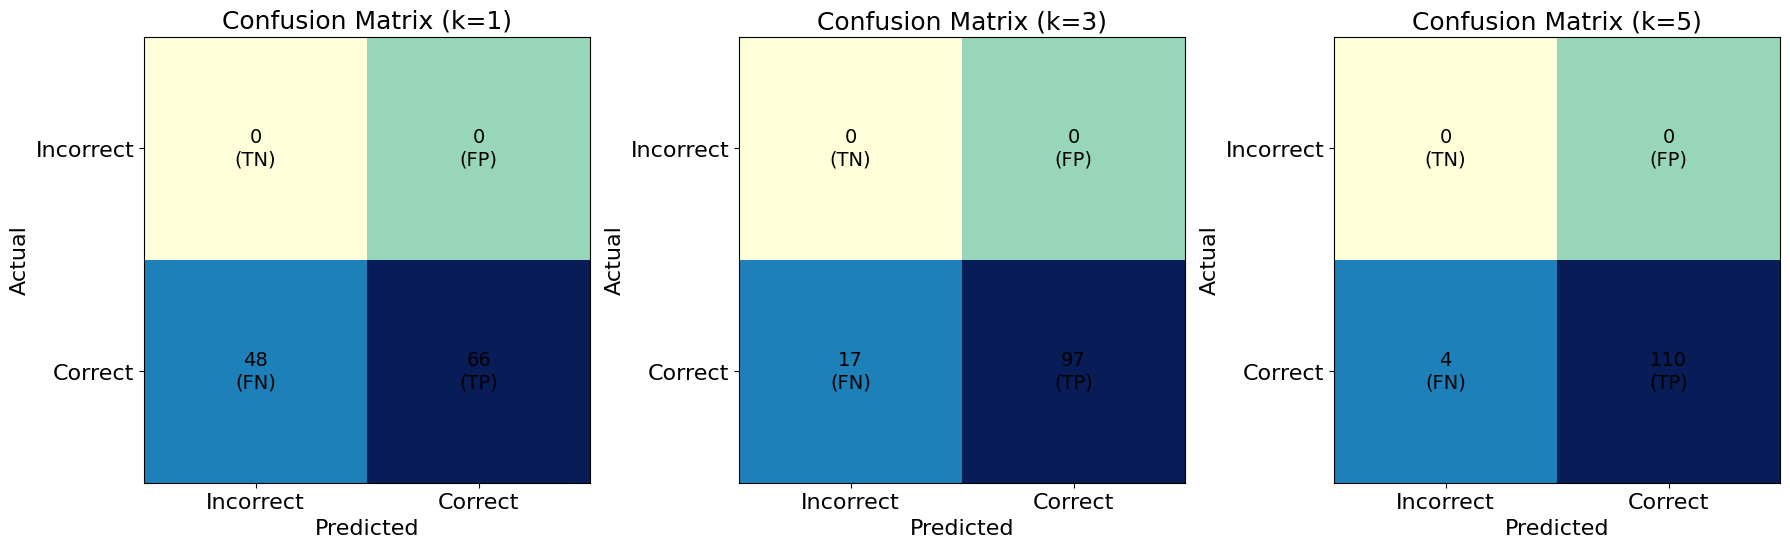

In [11]:
# Plot three confusion matrices (for k=1, k=3, and k=5)
plot_confusion_matrices(cm_k1, cm_k3, cm_k5, title1="k=1", title2="k=3", title3="k=5")

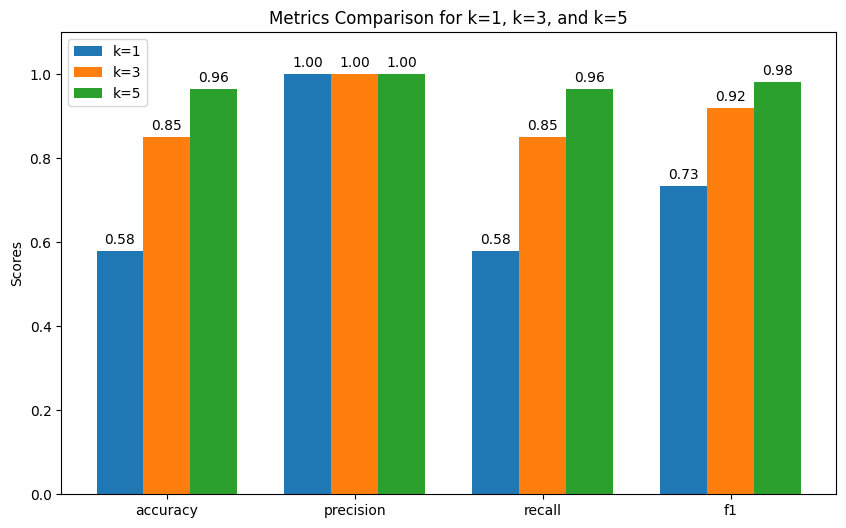

In [12]:
# Plot bar chart comparing the metrics for k=1, k=3, and k=5.
plot_three_metrics_comparison(metrics_k1, metrics_k3, metrics_k5, label1="k=1", label2="k=3", label3="k=5")